In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time

In [ ]:
mp_drawing = mp.solutions.drawing_utils # utilitário para desenhar landmarks
mp_face_mesh = mp.solutions.face_mesh # solução do mediapipe para mesh facial

# Pontos dos Olhos

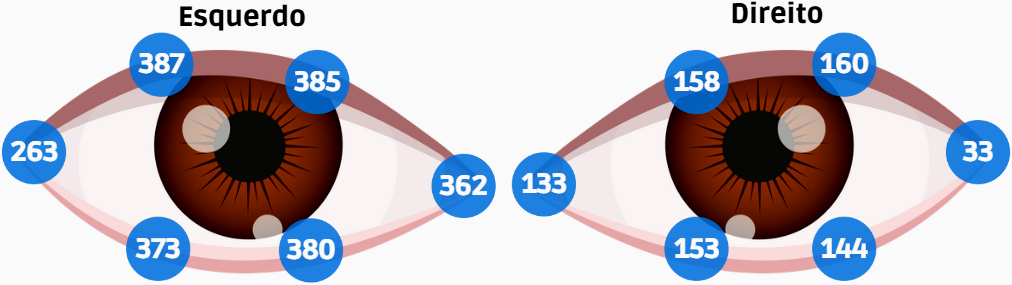

In [ ]:
# definição dos números correspondentes aos pontos dos olhos
p_olho_esq = [385, 380, 387, 373, 362, 263]
p_olho_dir = [160, 144, 158, 153, 33, 133]

In [ ]:
# agora, temos todos os pontos de ambos os olhos em um só array
p_olhos = p_olho_esq + p_olho_dir
p_olhos

[385, 380, 387, 373, 362, 263, 160, 144, 158, 153, 33, 133]

# Cálculo EAR

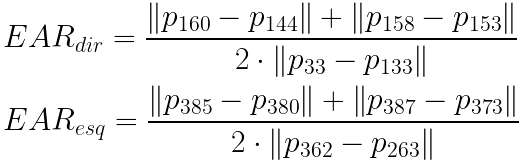

In [ ]:
def calculo_ear(face, p_olho_dir,p_olho_esq):
    try:
        face = np.array([[coord.x, coord.y] for coord in face]) # converte os pontos para array numpy
        face_esq = face[p_olho_esq,:]
        face_dir = face[p_olho_dir,:]
        
        # fórmula do EAR para cada olho
        ear_esq = (np.linalg.norm(face_esq[0]-face_esq[1])+np.linalg.norm(face_esq[2]-face_esq[3]))/(2*(np.linalg.norm(face_esq[4]-face_esq[5])))
        ear_dir = (np.linalg.norm(face_dir[0]-face_dir[1])+np.linalg.norm(face_dir[2]-face_dir[3]))/(2*(np.linalg.norm(face_dir[4]-face_dir[5])))
    except: # except para tratar o erro de divisão por zero
        ear_esq = 0.0
        ear_dir = 0.0
    media_ear = (ear_esq+ear_dir)/2 # faz a média dos dois EARs (olho esq e olho dir)
    return media_ear # retorna o valor do EAR

# Pontos da Boca

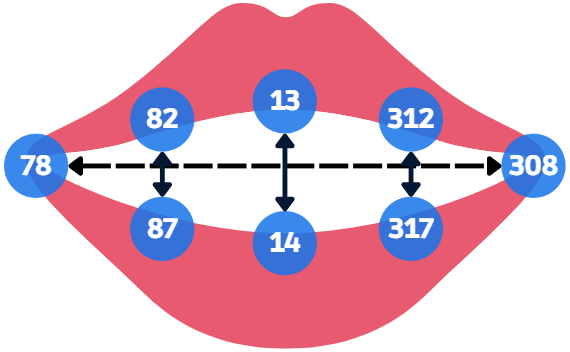

In [ ]:
# definição dos valores que correspondem aos pontos da boca
p_boca = [82, 87, 13, 14, 312, 317, 78, 308]

# Cálculo MAR

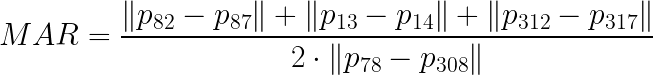

In [ ]:
def calculo_mar(face,p_boca):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_boca = face[p_boca,:]

        # fórmula do MAR (abertura da boca)
        mar = (np.linalg.norm(face_boca[0]-face_boca[1])+np.linalg.norm(face_boca[2]-face_boca[3])+np.linalg.norm(face_boca[4]-face_boca[5])) / (2*(np.linalg.norm(face_boca[6]-face_boca[7])))
    except:
        mar = 0.0 # tratamento de erro para evitar divisão por zero

    return mar # retorna o valor do MAR

# Executável

In [ ]:
ear_limiar = 0.3 # EAR abaixo de 0.3 é considerado 'olho fechado'
mar_limiar = 0.12 # MAR acima de 0.12 é considerado 'boca aberta'
dormindo = 0
contagem_piscadas = 0
c_tempo = 0
contagem_temporaria = 0
contagem_lista = []

t_piscadas = time.time() # referência de tempo inicial
cap = cv2.VideoCapture(0)# inicializa a camera

with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        sucesso, frame = cap.read()
        if not sucesso:
            print('Ignorando o frame vazio da câmera.')
            continue
        comprimento, largura, _ = frame.shape # guarda dimensões para converter coords

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # converte para RGB (exigencia do mediapipe)
        saida_facemesh = facemesh.process(frame) # detecta os pontos da face
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # converte novamente para BGR, para exibit com opencv
        
        try:
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                # desenha os contornos do rosto
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255,102,102),thickness=1,circle_radius=1),
                    connection_drawing_spec = mp_drawing.DrawingSpec(color=(102,204,0),thickness=1,circle_radius=1))
                face = face_landmarks.landmark
                # desenha os círculos coloridos nos olhos e na boca
                for id_coord, coord_xyz in enumerate(face):
                    if id_coord in p_olhos:
                       coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                       cv2.circle(frame, coord_cv, 2, (255,0,0), -1)
                    if id_coord in p_boca:
                       coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x,coord_xyz.y, largura, comprimento)
                       cv2.circle(frame, coord_cv, 2, (255,0,0), -1)

                # cálculos do EAR e MAR
                ear = calculo_ear(face,p_olho_dir, p_olho_esq)
                mar = calculo_mar(face, p_boca)

                # exibe os valores calculados no vídeo em tempo real
                cv2.rectangle(frame, (0,1),(290,140),(58,58,55),-1)
                cv2.putText(frame, f"EAR: {round(ear, 2)}", (1, 24),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)
                cv2.putText(frame, f"MAR: {round(mar, 2)} {'Aberto' if mar>=mar_limiar else 'Fechado'}", (1, 50),
                                cv2.FONT_HERSHEY_DUPLEX,
                                0.9, (255, 255, 255), 2)

                # verifica se o EAR está menor que o limiar E o MAR está menor que o limiar (olhos e boca fechada) -> sono
                if ear < ear_limiar and mar < mar_limiar:
                    # se o condutor ainda não estava dormindo, marca o tempo inicial do sono
                    t_inicial = time.time() if dormindo == 0 else t_inicial
                    # incrementa a contagem de piscadas apenas se ele está acordado (evitar contagem infinita)
                    contagem_piscadas = contagem_piscadas + 1 if dormindo == 0 else contagem_piscadas
                    # usuário se torna dormindo
                    dormindo = 1

                # se o condutor estava dormindo e o EAR subiu ou se o EAR está baixo, mas a boca está aberta (risada)
                if (dormindo == 1 and ear >= ear_limiar) or (ear <= ear_limiar and mar>=mar_limiar):
                    dormindo = 0 # não está dormindo
                # marca o tempo atual para o cálculo do tempo decorrido
                t_final = time.time()
                # calcula o tempo decorrido desde a última medição das piscadas por segundo
                tempo_decorrido = t_final - t_piscadas

                # se passou pelo menos um segundo desde a última contagem
                if tempo_decorrido >= (c_tempo+1):
                    c_tempo = tempo_decorrido # atualiza  marcador de tempo
                    piscadas_ps = contagem_piscadas - contagem_temporaria # calcula o numero de piscadas no último segundo
                    contagem_temporaria = contagem_piscadas # atualiza a contagem temporaria para a proxima medição
                    contagem_lista.append(piscadas_ps) # atualiza o numero de piscadas por segundo na lista que armazena os ultimos 60s
                    # mantém somente os últimos 60 valores (último min)
                    contagem_lista = contagem_lista if (len(contagem_lista) <= 60) else contagem_lista[-60:]
                
                # calcula as piscadas por min, se o tempo for menor ou igual a 60s, assume 15 piscadas por min por padrão
                # caso contrario, soma as piscadas nos ultimos 60s
                piscadas_pm = 15 if tempo_decorrido <= 60 else sum(contagem_lista)

                cv2.putText(frame, f"Piscadas: {contagem_piscadas}", (1, 120),
                                            cv2.FONT_HERSHEY_DUPLEX,
                                            0.9, (109, 233, 219), 2)
                # calcula o tempo total que o usuario está dormindo, se não estiver dormindo, tempo é 0                            
                tempo = (t_final-t_inicial) if dormindo == 1 else 0.0
                cv2.putText(frame, f"Tempo: {round(tempo, 3)}", (1, 80),
                                        cv2.FONT_HERSHEY_DUPLEX,
                                        0.9, (255, 255, 255), 2)
                # se estiver piscando pouco e o tempo de dormindo for maior ou igual a 1.5s, exibe um aviso
                if piscadas_pm < 10 or tempo>=1.5:
                    cv2.rectangle(frame, (30, 400), (610, 452), (0, 0, 100), -1)
                    cv2.putText(frame, f"Talvez você esteja com sono,", (60, 420),
                                        cv2.FONT_HERSHEY_DUPLEX, 
                                        0.85, (58,58,55), 1)
                    cv2.putText(frame, f"descanse.", (180, 450),
                                        cv2.FONT_HERSHEY_DUPLEX, 
                                        0.85, (58,58,55), 1)
        except: # garantir que erros não interrompam o programa
            pass
            
        # exibe o frame com as informações e desenhos no rosto
        cv2.imshow('Camera',frame)
        if cv2.waitKey(10) & 0xFF == ord('c'): # apertar a tecla 'c' para fechar
            break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
for face_landmarks in saida_facemesh.multi_face_landmarks:
    face = face_landmarks
    for id_coord, coord_xyz in enumerate(face.landmark):
        print(id_coord)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27